In [1]:
from pykat import finesse 
       
from pykat.commands import *     
import numpy as np   
import pandas as pd            
import matplotlib.pyplot as plt  
import scipy.signal                
from IPython import display
              
%matplotlib inline
pykat.init_pykat_plotting(dpi=200)

                                              ..-
    PyKat 1.2.81          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



--------------------------------------------------------------
Running kat - Started at 2023-01-10 19:30:47.664612


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /home/plutonium/anaconda3/bin/kat

Finished in 16.7755 seconds

--- Output info ---

Run date and time: 2023-01-10 19:30:47.664916
Detectors used: circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis PRM phi lin 30 110 8000']
circ_arm : min = 4.147472404304740e+02 max = 1.495971607104210e+05
circ_prc : min = 1.262642685203770e+00 max = 3.905636697910070e+02
refl     : min = 1.222697604721150e+00 max = 2.868081739260220e+01
trans    : min = 4.147638309837130e-03 max = 1.496031448362150e+00


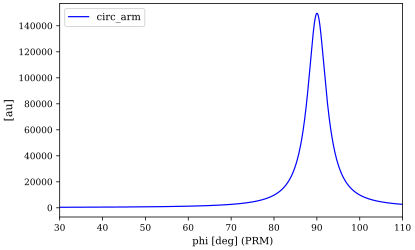

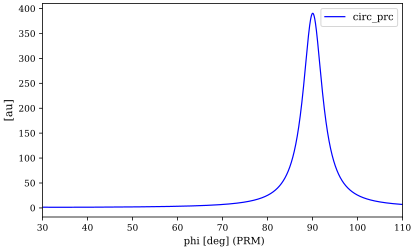

max power arm 149597.160710421
max power prc 390.563669791007
array number [[6003]]
PRM tuning for max power in arm and prc [[90.03]]


In [2]:
kat1 = finesse.kat()
kat1.verbose=True
kat1.parse("""

l laser 30 0 n1                          #laser 30W
maxtem 3
s gap01 1 n1 n2                         #space b/w mod and laser  
mod eom1 $sb1 0.18 3 pm n2 n3         #modulator PM $sb1 3f
s gap02 0.5 n3 n31a                     #space b/w mod and PRM      


##### FOR ANGULAR SENSING PRM #####
bs pickoff 0.0001 0.9999 0 45 n31a dump n32 refl_a
s s2 0.1 refl_a a8                       
bs bsQPD 0.5 0.5 0 45 a8 a9 a10 dump            #bs to split power between two detectors 

s sQPD1 0.1 a9 a11                   
s sQPD2 0.1 a10 a12
#########################


####### 3 m setup ###########

s gap03 0.5 n32 refl

m PRM 0.859 0.1 0 refl pop               #PRM                ---> POP <---

#m PRM 0 1 90 refl pop

##### folding mirrors #####
s prc 0.5 pop bs1a
bs bs1 0.999 0.001 0 0 bs1a bs12 bs12tr dump
s b1 0.350 bs12 bs21
bs bs2 0.999 0.001 0 0 bs21 bs21a bs21tr dump
s b2 0.5 bs21a b3    
###########################

#m PRM 0 1 90 refl pop               #PRM
#s PRC 1.33 pop b3                        #PRC 
m ITM 0.98997 0.01 0 b3 n12              #ITM
s ARM 3.3 n12 b5                        #ARM length 3.3 (0.01 from sr length) 
m ETM 0.99996 0.00001 0 b5 b6           #ETM
#m ETM 0 1 0 b5 b6 

################################


cav ARML ITM n12 ETM b5 
cav PRCL PRM pop ITM b3



##### attr for TM ######
attr ETM Rc 11.3            # RoC of ETM
attr PRM Rc -23.6           # RoC of PRM
attr PRM xbeta 0            # misalgnment PRM
attr ETM xbeta 0            # misalgnment ETM
attr ITM xbeta 0            # misalgnment ITM
######################


#trace 2 
#phase 2

const sb1 55.556M
const sb2 111.112M
const sb3 166.668M



""")


#### DC PDs ##########

kat_dc = kat1.deepcopy()
kat_dc.parse("""

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


xaxis PRM phi lin 30 110 8000


""")

out_dc = kat_dc.run()
out_dc.info()
out_dc.plot(['circ_arm'])
out_dc.plot(['circ_prc'])
print("max power arm",max(out_dc['circ_arm']))
print("max power prc",max(out_dc['circ_prc']))
print("array number",np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm'])))
print("PRM tuning for max power in arm and prc",out_dc.x[np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm']))])


### SET PRM phi ###
kat1.PRM.phi = out_dc.x[np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm']))]

In [3]:
m = 50/1000 ## mass 340gm
r = 25/(100*10*2)    ## dia 75mm
d = 6/(100*10)    ## thickness 6mm

Iz = 0.5*m*r*r
Ix = (0.25*m*r*r) + (1/12)*(m*d*d)

print("MoI Iz",Iz)
print("MoI Ix",Ix)

MoI Iz 3.906250000000001e-06
MoI Ix 2.1031250000000003e-06


[591.05910591]
[1102.01020102]


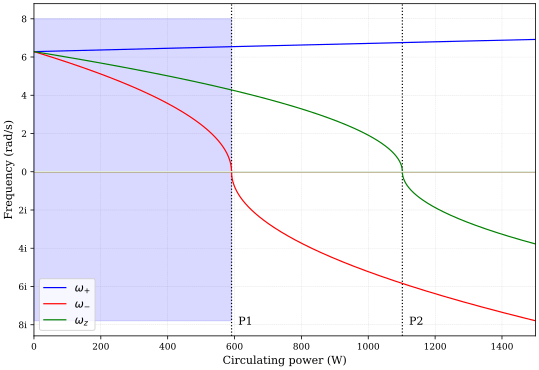

In [4]:
w0 = 1*(2*np.pi)
L = 3.3
#I = 0.000047
I = Ix
c = 3*1e8
g1 = 0.708
g2 = 1

x = np.linspace(0, 0.000150*10e6, 10000)

y_1 = ((w0**2) + ((x*L)/(I*c))*(-(g1+g2)+(4+(g1-g2)**2)**0.5)/(1-g1*g2))**0.5

y_2 = np.real(np.emath.sqrt((((w0**2) + ((x*L)/(I*c))*(-(g1+g2)-(4+(g1-g2)**2)**0.5)/(1-g1*g2)))))
y_21 = -1*np.imag(np.emath.sqrt((((w0**2) + ((x*L)/(I*c))*(-(g1+g2)-(4+(g1-g2)**2)**0.5)/(1-g1*g2)))))

y_3 = np.real(np.emath.sqrt((((w0**2)-(2*x*L/(c*I))*(g2/(1-g2*g1))))))
y_31 = -1*np.imag(np.emath.sqrt((((w0**2)-(2*x*L/(c*I))*(g2/(1-g2*g1))))))


y_2zero = x[np.argwhere(y_2 == 0)[0]]
y_3zero = x[np.argwhere(y_3 == 0)[0]]


plt.figure(figsize=(9, 6))

plt.axvline(x=y_2zero,linestyle = "dotted",color = "black")
plt.axvline(x=y_3zero,linestyle = "dotted",color = "black") 

label = ['10i', '8i', '6i', '4i','2i','0','2','4','6','8']
plt.plot(x, y_1,label="$\\omega_{\plus}$")
plt.plot(x, y_2,color = 'red',label="$\\omega_{\minus}$")
plt.plot(x, y_3,color = 'green',label="$\\omega_{z}$")
plt.plot(x, y_21,color = 'red')
plt.plot(x, y_31,color = 'green')
plt.yticks(range(-10,10,2),label)
plt.axhline(y=0,color="white")
plt.xlabel("Circulating power (W)")
plt.ylabel("Frequency (rad/s)")
plt.text(y_2zero+20,-8,'P1')
plt.text(y_3zero+20,-8,'P2')
plt.fill_between(x,min(y_21),8,where= x < y_2zero,color='blue', alpha=.15)
plt.legend()
print(y_2zero)
print(y_3zero)

--------------------------------------------------------------
Running kat - Started at 2023-01-10 19:31:07.131926


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /home/plutonium/anaconda3/bin/kat

Finished in 1.10461 seconds
2.005


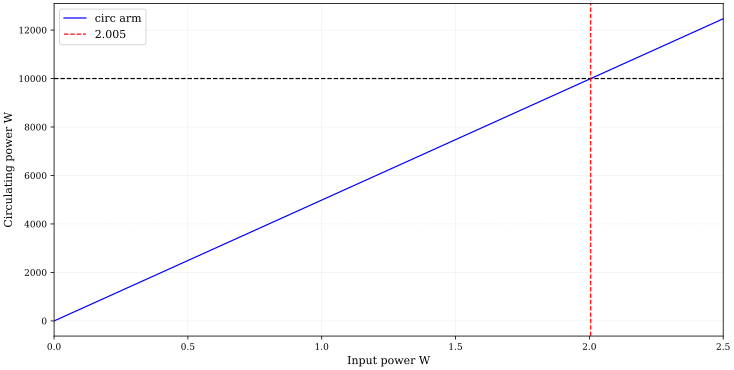

In [5]:
optimum_power = 10000
ip = kat1.laser.P
kat1.ETM.phi = 0
kat_tf2 = kat1.deepcopy()
kat_tf2.parse("""

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


xaxis laser P lin 0 2.5 500

""")
plt.figure(figsize=(12, 6))
out_df2 = kat_tf2.run()
plt.plot(out_df2.x,out_df2['circ_arm'],label = "circ arm")
plt.axhline(y = optimum_power,linestyle = "--",color = "black")
difference_array = np.absolute(out_df2['circ_arm']-optimum_power)
index = difference_array.argmin()
plt.axvline(x = out_df2.x[index],label = out_df2.x[index],linestyle = "--",color = "red")
plt.xlabel("Input power W")
plt.ylabel("Circulating power W")
plt.legend()
print(out_df2.x[index])

In [6]:
kat_dc.laser.P = out_df2.x[index]
out_dc1 = kat_dc.run()
out_dc1.info()
max_arm = max(out_dc1['circ_arm'])
max_prc = max(out_dc1['circ_prc'])
print("max power arm",max(out_dc1['circ_arm']))
print("max power prc",max(out_dc1['circ_prc']))
print(kat_dc.laser.P)

--------------------------------------------------------------
Running kat - Started at 2023-01-10 19:31:08.711332


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /home/plutonium/anaconda3/bin/kat

Finished in 16.802 seconds

--- Output info ---

Run date and time: 2023-01-10 19:31:08.712811
Detectors used: circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis PRM phi lin 30 110 8000']
circ_arm : min = 2.771894056877000e+01 max = 9.998076907479821e+03
circ_prc : min = 8.438661946111890e-02 max = 2.610267193103230e+01
refl     : min = 8.171695658219739e-02 max = 1.916834629072250e+00
trans    : min = 2.772004937074490e-04 max = 9.998476846553690e-02
max power arm 9998.07690747982
max power prc 26.1026719310323
2.005


max constant -80578.02463556113
detuning [-0.00113064]
K= -80578.02463556113
156207.93449410563


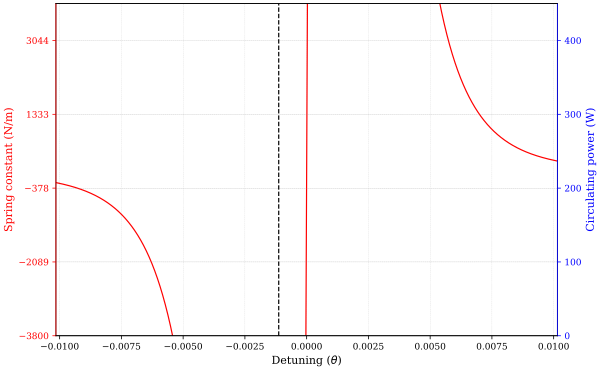

In [7]:
lamb = 1064*1e-9
xi = ((np.linspace(-0.0030e-8,0.0030e-8,8000))*360)/lamb

c = 299792458
ga = max_arm/max_prc
gb = max_prc/out_df2.x[index]
#F = 620
F = 4*((kat1.ETM.R*kat1.ITM.R)**0.5)/(1-(kat1.ETM.R*kat1.ITM.R)**0.5)**2
Pin = out_df2.x[index]
P0 = (ga)*(gb)*Pin*(1/(1+F*(np.sin(xi)**2)))
K = (8*np.pi*P0*F*xi)/(c*lamb*(1+F*xi**2)**2)


fig, ax1 = plt.subplots(figsize=(9,6))
ax2 = ax1.twinx()

ax1.plot(xi, K,color = "red")
ax2.plot(xi, P0,color = "blue")
ax2.set_ylim((0,450))
ax2.set_yticks(range(0,450,100))
ax1.set_ylim(-3800,3900)
ax1.set_yticks(range(-3800,3900,1711))
ax1.set_xlabel("Detuning ($\\theta$)")
ax1.set_ylabel("Spring constant (N/m)", color="red")
ax2.set_ylabel("Circulating power (W)", color="blue")
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')
ax1.tick_params(axis='y', colors='red') 
ax2.tick_params(axis='y', colors='blue') 
#plt2 = plt.twinx()

#plt.plot(xi,K,label="optical spring constant N/m",color = "red")
#plt2.plot(xi,P0,label="circ power W")


print("max constant",min(K))
plt.axvline(x= xi[np.where(K == min(K))],linestyle = "--",color ="black")
#plt.axhline(y=min(K),label = "max constant " +str(max(K)) +" \nat detuning " + str(xi[np.where(K == min(K))]),linestyle = "--")
print("detuning",xi[np.where(K == min(K))])
#plt.legend()
print("K=",min(K))
print(F)

Force 1.287943508983497e-10
nanoForce 0.1287943508983497
Young's modulus -137734594392.8464
Young's modulus wrt diamond -0.13117580418366323


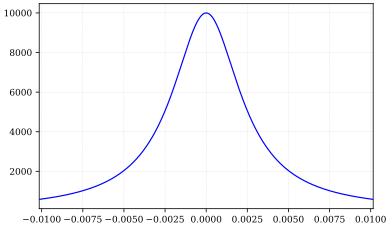

In [11]:
plt.plot(xi,P0)
r = 0.00156782945845/2
E = min(K)*3.3/(np.pi*r*r)
print("Force",(2/c)*optimum_power*np.pi*r*r)
print("nanoForce",(2/c)*optimum_power*np.pi*r*r/(1e-9))
print("Young's modulus",E)
print("Young's modulus wrt diamond",E/(1.05*1e12))